In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

columns1 = inspector.get_columns('measurement')
for column in columns1:
    print(column["name"], column["type"])

columns2 = inspector.get_columns('station')
for column in columns2:
    print(column["name"], column["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
engine.execute('Select * FROM measurement LIMIT 1').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0)]

In [12]:
engine.execute('Select * FROM station LIMIT 1').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

# Exploratory Climate Analysis

2017-08-23
2016-08-23 00:00:00


<function matplotlib.pyplot.show(close=None, block=None)>

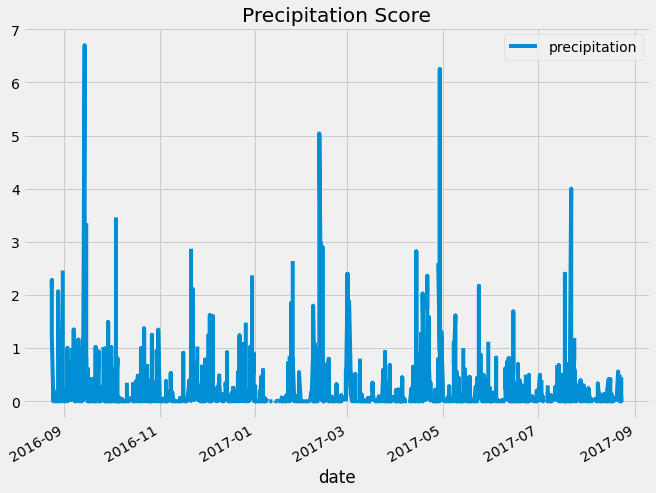

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
earliest_date = session.query(measurement.date).order_by(measurement.date).first()
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

latest_date = latest_date[0]
print(latest_date)

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)
print(last_year)

# Perform a query to retrieve the data and precipitation scores
precipitation_scores_query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()
precipitation_scores_query

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_scores_df = pd.DataFrame(precipitation_scores_query, columns=['date', 'precipitation'])

# Change datatype
precipitation_scores_df['date'] = pd.to_datetime(precipitation_scores_df['date'], format='%Y-%m-%d')

# Sort the dataframe by date
precipitation_scores_df.set_index('date', inplace=True)
precipitation_scores_df = precipitation_scores_df.sort_values(by='date', ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data
precipitation_scores_df.plot(title="Precipitation Score", figsize=(10, 8))
plt.legend(loc='upper right')
plt.savefig("Images/Precipitation.png")
plt.show

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_scores_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Stations Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(measurement.station).distinct().count()
print(f"Number of available stations: {available_stations} ")

Number of available stations: 9 


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
print("Most active stations:")
most_active

Most active stations:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_stations = most_active[0][0]
temp_calculation = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == most_active_stations).all()

print(f"Highs, Lows, and Average Temperature")
print(F"Low: {temp_calculation[0][0]} High: {temp_calculation[0][1]} Average: {temp_calculation[0][1]}")

Highs, Lows, and Average Temperature
Low: 54.0 High: 85.0 Average: 85.0


In [18]:
# Choose the station with the highest number of temperature observations.
highest_temp_obs = session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
highest_temp_obs = highest_temp_obs[0]

# Query the last 12 months of temperature observation data for this station
temperature_obs = session.query(measurement.tobs).filter(measurement.date>=last_year).filter(measurement.station == highest_temp_obs).all()
temperature_obs_df = pd.DataFrame(temperature_obs, columns=['temperature'])
temperature_obs_df.head()

,temperature
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


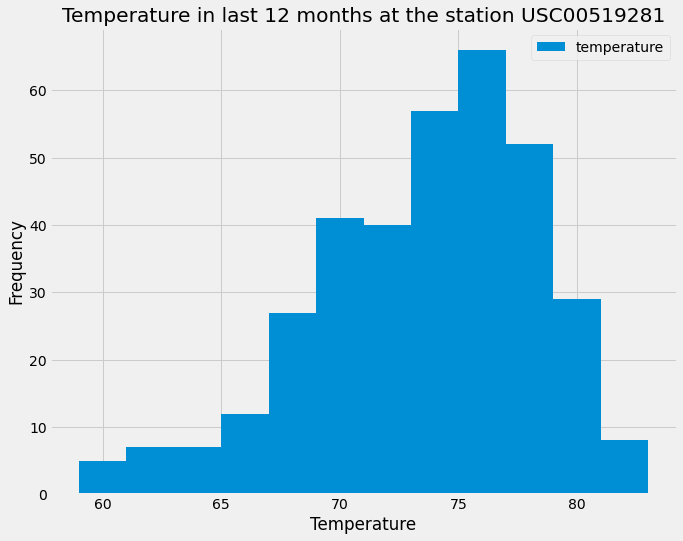

In [19]:
ax = temperature_obs_df.plot.hist(bins=12, figsize=(10,8))
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.grid(True)
plt.title(f'Temperature in last 12 months at the station {highest_temp_obs}')

plt.savefig(f"Images/{highest_temp_obs}_temp_histogram.png")
plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_calc_temps = calc_temps('2017-01-01', '2017-01-14')
trip_calc_temps


[(60.0, 68.47619047619048, 81.0)]

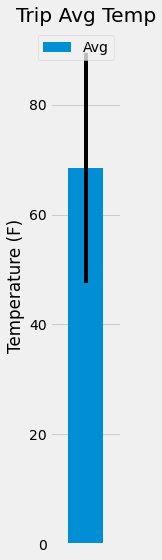

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_calc_temps_df = pd.DataFrame(trip_calc_temps, columns=['Min', 'Avg', 'Max'])
trip_calc_temps_df

figsize=(6,8)
trip_calc_temps_df.plot.bar(y='Avg', yerr=(trip_calc_temps_df['Max'] - trip_calc_temps_df['Min']), figsize=(2,8), title='Trip Avg Temp')
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("Images/trip_calc_temps.png")
plt.show()


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def rainfall(start_date, end_date):
    selection = [measurement.station, station.name, station.latitude, station.longitude, station.elevation, measurement.prcp]
    return session.query(*selection).filter(measurement.station == station.station).filter(measurement.date >= start_date).filter(measurement.date <= end_date).group_by(measurement.station).order_by(measurement.prcp.desc()).all()

print(rainfall('2017-01-01','2017-01-10'))

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.03), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.03), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
